In [22]:
from knn_chain import knn_chain

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import mmread, loadmat

# Time complexity analysis packages
import pstats, cProfile
import pyximport
pyximport.install()

# Memory complexity analysis packages
import tracemalloc

# Datasets
import tensorflow as tf

# FUNCTIONS

In [7]:
def record_runtimes(X, ks, n = 10):
    
    avgs = []
    for k in ks:
        avg = 0.0
        for i in range(n):
            cProfile.runctx("knn_chain(X, k)", globals(), locals(), "Profile.prof")
            k1 = pstats.Stats("Profile.prof")
            avg += k1.strip_dirs().sort_stats("time").total_tt

        avg = avg/n
        avgs.append(avg)
        print(f"avg, k = {k} = {avg}")

    return avgs

In [8]:
def plot_runtimes(ks, avgs):
    plt.plot(ks, avgs, marker='o', c = '#D81B60', alpha=0.7)

    for i, avg in enumerate(avgs):
        plt.text(ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=10, color='#000000', fontweight='bold')


    plt.title("Execution time comparison")
    plt.xlabel("Value of k")
    plt.xticks(ticks=ks, labels=[str(k) for k in ks]) 
    plt.ylabel("Execution time in seconds")
    plt.grid(c = "#d3d3d3")

    margin = 1.3
    plt.xlim(min(ks) - margin, max(ks) + margin)

    plt.show()

# VARIABLES

In [9]:
n = 20
ks = [1, 3, 6, 10, 15]

# EXPERIMENTS

## Time Complexity

## 1. small X

In [20]:
s_X = np.loadtxt("datasets/generated_smallX")
avgs_small_gen = record_runtimes(X, ks, n)

avg, k = 1 = 0.02270951125
avg, k = 3 = 0.020055988150000002
avg, k = 6 = 0.02152903665
avg, k = 10 = 0.022986338100000003
avg, k = 15 = 0.0236995462


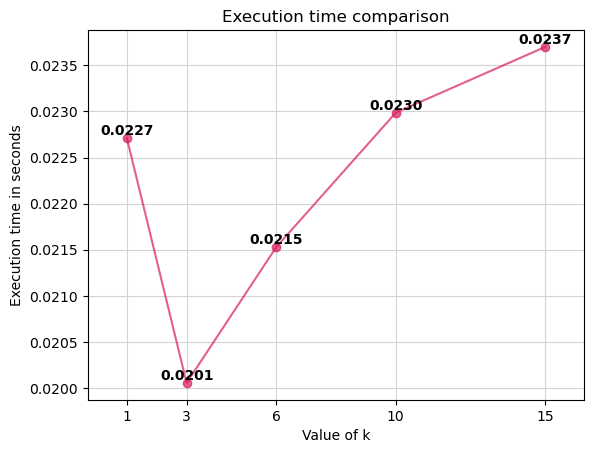

In [72]:
plot_runtimes(ks, avgs_small_gen)

## 2. medium X

avg, k = 1 = 0.71488068785
avg, k = 3 = 0.5917478258
avg, k = 6 = 0.54107109315
avg, k = 10 = 0.55368558045
avg, k = 15 = 0.56659320355


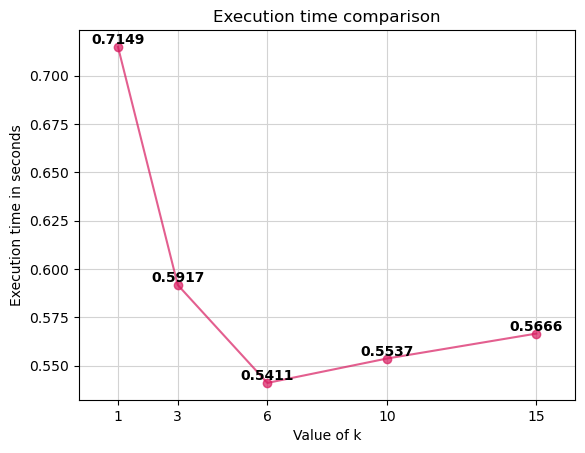

In [73]:
med_X = np.loadtxt("datasets/generated_mediumX")
avgs_med_gen = record_runtimes(med_X, ks, n)
plot_runtimes(ks, avgs_med_gen)

## 3. large X

avg, k = 1 = 2.9384835022999996
avg, k = 3 = 2.25442247965
avg, k = 6 = 2.1617690972500005
avg, k = 10 = 2.1651844017500004
avg, k = 15 = 2.2024546772500004


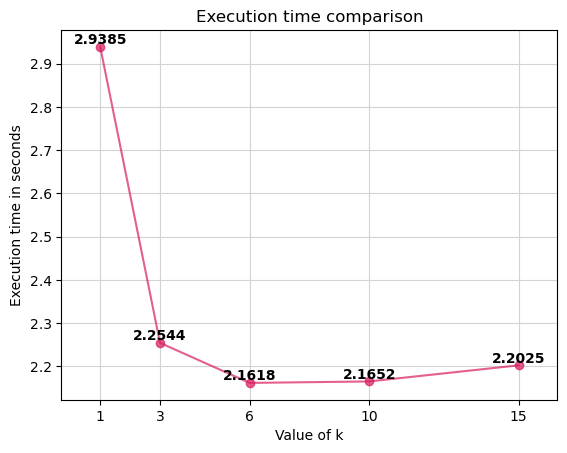

In [74]:
large_X = np.loadtxt("datasets/generated_largeX")
avgs_large_gen = record_runtimes(large_X, ks, n)
plot_runtimes(ks, avgs_large_gen)

## 4. extra large X

avg, k = 1 = 6.957992400250001
avg, k = 3 = 5.30109754025
avg, k = 6 = 4.93085242195
avg, k = 10 = 4.899931189000001
avg, k = 15 = 4.974749849949999


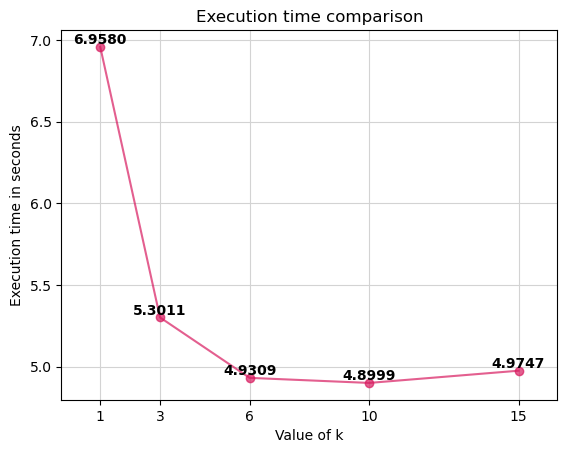

In [75]:
xl_X = np.loadtxt("datasets/generated_xlargeX")
avgs_xl_gen = record_runtimes(xl_X, ks, n)
plot_runtimes(ks, avgs_xl_gen)

## 5. extra extra large X

avg, k = 1 = 14.521160413500002
avg, k = 3 = 10.91834577565
avg, k = 6 = 11.64719696605
avg, k = 10 = 10.653050424649999
avg, k = 15 = 10.572595866099999


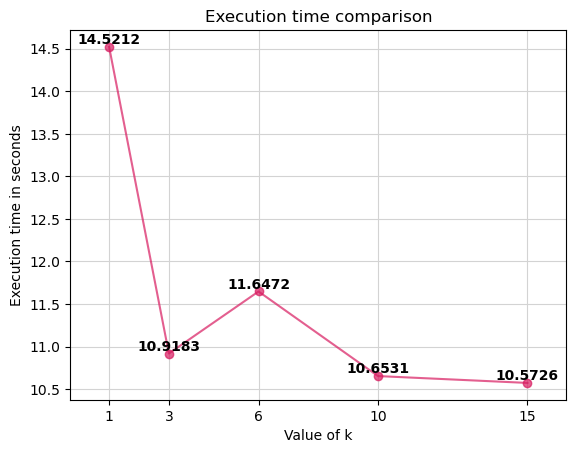

In [76]:
xxl_X = np.loadtxt("datasets/generated_xxlargeX")
avgs_xxl_gen = record_runtimes(xxl_X, ks, n)
plot_runtimes(ks, avgs_xxl_gen)

## All of the values in one plot

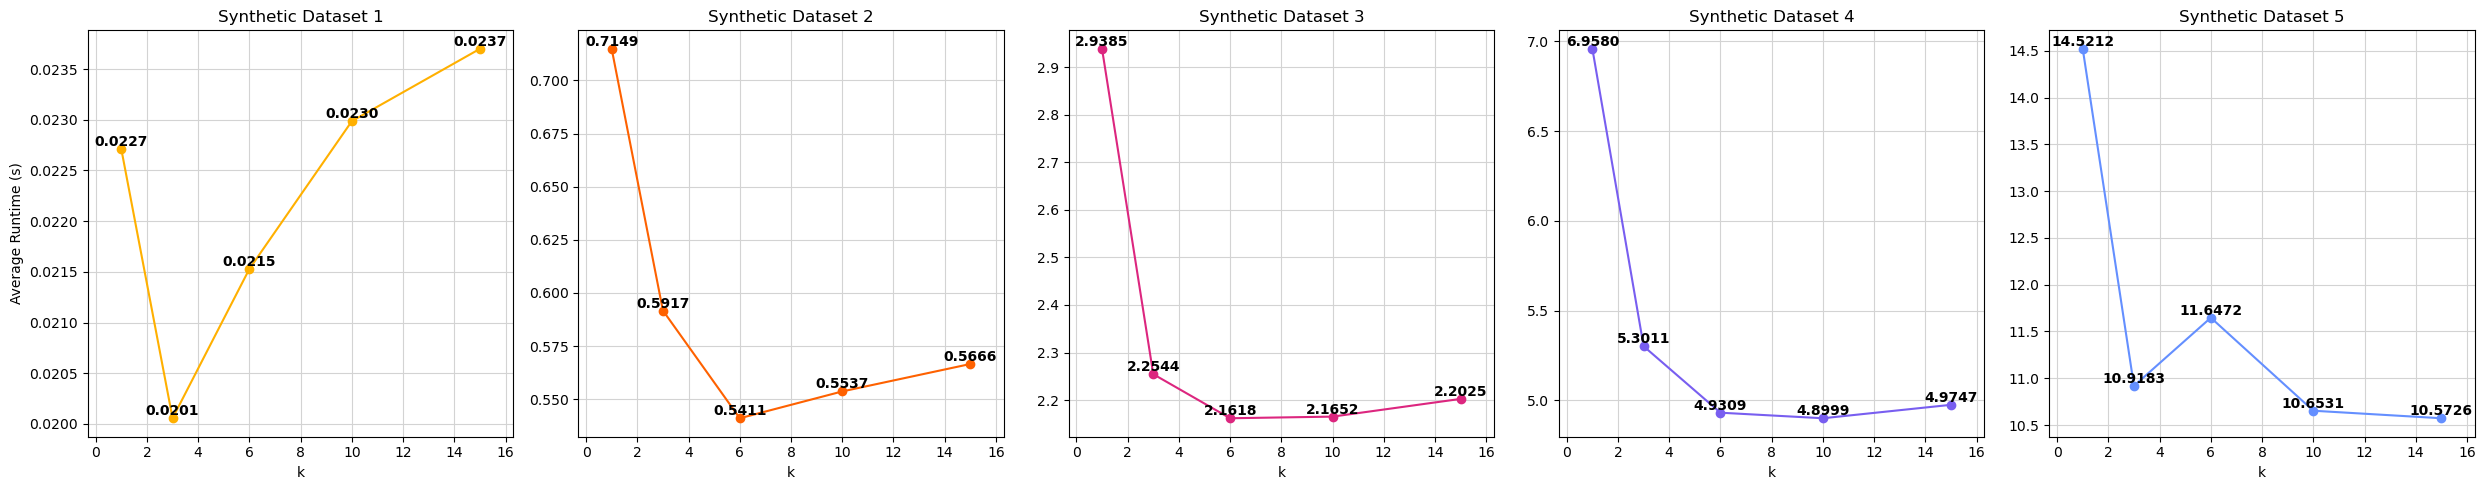

In [83]:
# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=False, sharey=False)
margin = 1.3

# Define a function to set axis limits with margins
def set_axis_limits(ax, x, y, margin):
    ax.set_xlim([min(x) - margin, max(x) + margin])

# Plot for the first runtime list
axes[0].plot(ks, avgs_small_gen, marker='o', color='#FFB000')
for i, avg in enumerate(avgs_small_gen):
    axes[0].text(ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=10, color='#000000', fontweight='bold')
axes[0].set_title('Synthetic Dataset 1')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Average Runtime (s)')
axes[0].grid(c = "#d3d3d3")
set_axis_limits(axes[0], ks, avgs_small_gen, margin)

# Plot for the second runtime list
axes[1].plot(ks, avgs_med_gen, marker='o', color='#FE6100')
for i, avg in enumerate(avgs_med_gen):
    axes[1].text(ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=10, color='#000000', fontweight='bold')
axes[1].set_title('Synthetic Dataset 2')
axes[1].set_xlabel('k')
axes[1].grid(c = "#d3d3d3")
set_axis_limits(axes[1], ks, avgs_small_gen, margin)

# Plot for the third runtime list
axes[2].plot(ks, avgs_large_gen, marker='o', color='#DC267F')
for i, avg in enumerate(avgs_large_gen):
    axes[2].text(ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=10, color='#000000', fontweight='bold')
axes[2].set_title('Synthetic Dataset 3')
axes[2].set_xlabel('k')
axes[2].grid(c = "#d3d3d3")
set_axis_limits(axes[2], ks, avgs_large_gen, margin)

# Plot for the fourth runtime list
axes[3].plot(ks, avgs_xl_gen, marker='o', color='#785EF0')
for i, avg in enumerate(avgs_xl_gen):
    axes[3].text(ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=10, color='#000000', fontweight='bold')
axes[3].set_title('Synthetic Dataset 4')
axes[3].set_xlabel('k')
axes[3].grid(c = "#d3d3d3")
set_axis_limits(axes[3], ks, avgs_xl_gen, margin)

# Plot for the fifth runtime list
axes[4].plot(ks, avgs_xxl_gen, marker='o', color='#648FFF')
for i, avg in enumerate(avgs_xxl_gen):
    axes[4].text(ks[i], avg, f'{avg:.4f}', ha='center', va='bottom', fontsize=10, color='#000000', fontweight='bold')
axes[4].set_title('Synthetic Dataset 5')
axes[4].set_xlabel('k')
axes[4].grid(c = "#d3d3d3")
set_axis_limits(axes[4], ks, avgs_xxl_gen, margin)

# Adjust layout
plt.tight_layout()
plt.show()

## 6. MNIST

In [7]:
big_ks = [1, 6, 15, 30, 40]

In [5]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
n_images = x_train.shape[0]
X_images = x_train.reshape(n_images, 28, 28)
X = X_images.reshape(n_images, 28 * 28)

avg, k = 1 = 0.5894258190000001
avg, k = 3 = 0.582758271
avg, k = 6 = 0.49224305600000007
avg, k = 10 = 0.495156176
avg, k = 15 = 0.490314943


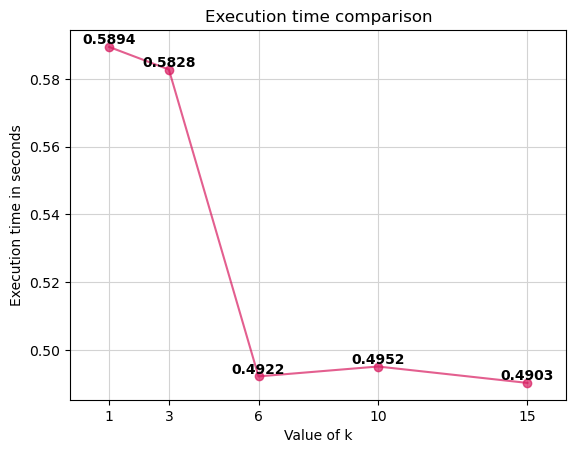

In [6]:
avgs_mnist = record_runtimes(X, big_ks, n=1)
plot_runtimes(big_ks, avgs_mnist)

## 7. BBC News

In [20]:
matrix = mmread('datasets/bbc.mtx')
bbc_matrix = matrix.toarray()

In [8]:
avgs_bbc = record_runtimes(bbc_matrix, big_ks, n=1)
plot_runtimes(big_ks, avgs_bbc)

## Memory Complexity

In [4]:
def record_memory(X, ks):
    mem = []
    for k in ks:
        tracemalloc.start()
        knn_chain(X, k)
        mem.append(tracemalloc.get_traced_memory()[1])
        tracemalloc.stop()
    return np.array(mem)

In [5]:
def wrapper_mem(X, ks, n):
    mem = np.zeros(len(ks))
    for _ in range(n):
        mem = mem + record_memory(X, ks)
    return mem/n

### Generated, synthetic data

In [3]:
s_X = np.loadtxt("datasets/generated_smallX")
med_X = np.loadtxt("datasets/generated_mediumX")
large_X = np.loadtxt("datasets/generated_largeX")
xl_X = np.loadtxt("datasets/generated_xlargeX")
xxl_X = np.loadtxt("datasets/generated_xxlargeX")

In [15]:
s_mem = wrapper_mem(s_X, ks, n)
print(s_mem)

[184541.8  184213.2  184216.   184242.95 184216.  ]


In [16]:
med_mem = wrapper_mem(med_X, ks, n)
print(med_mem)

[953196.7 953115.5 952987.2 953132.6 953072.4]


In [12]:
large_mem = wrapper_mem(large_X, ks, n)
print(large_mem)

[1911940.35 1911668.1  1911647.4  1911589.3  1911665.4 ]


In [13]:
xl_mem = wrapper_mem(xl_X, ks, n)
print(xl_mem)

[2873553.65 2873393.2  2873319.4  2873440.8  2873339.2 ]


In [14]:
xxl_mem = wrapper_mem(xxl_X, ks, n)
print(xxl_mem)

[3830062.95 3829777.75 3829846.4  3829931.6  3829910.8 ]


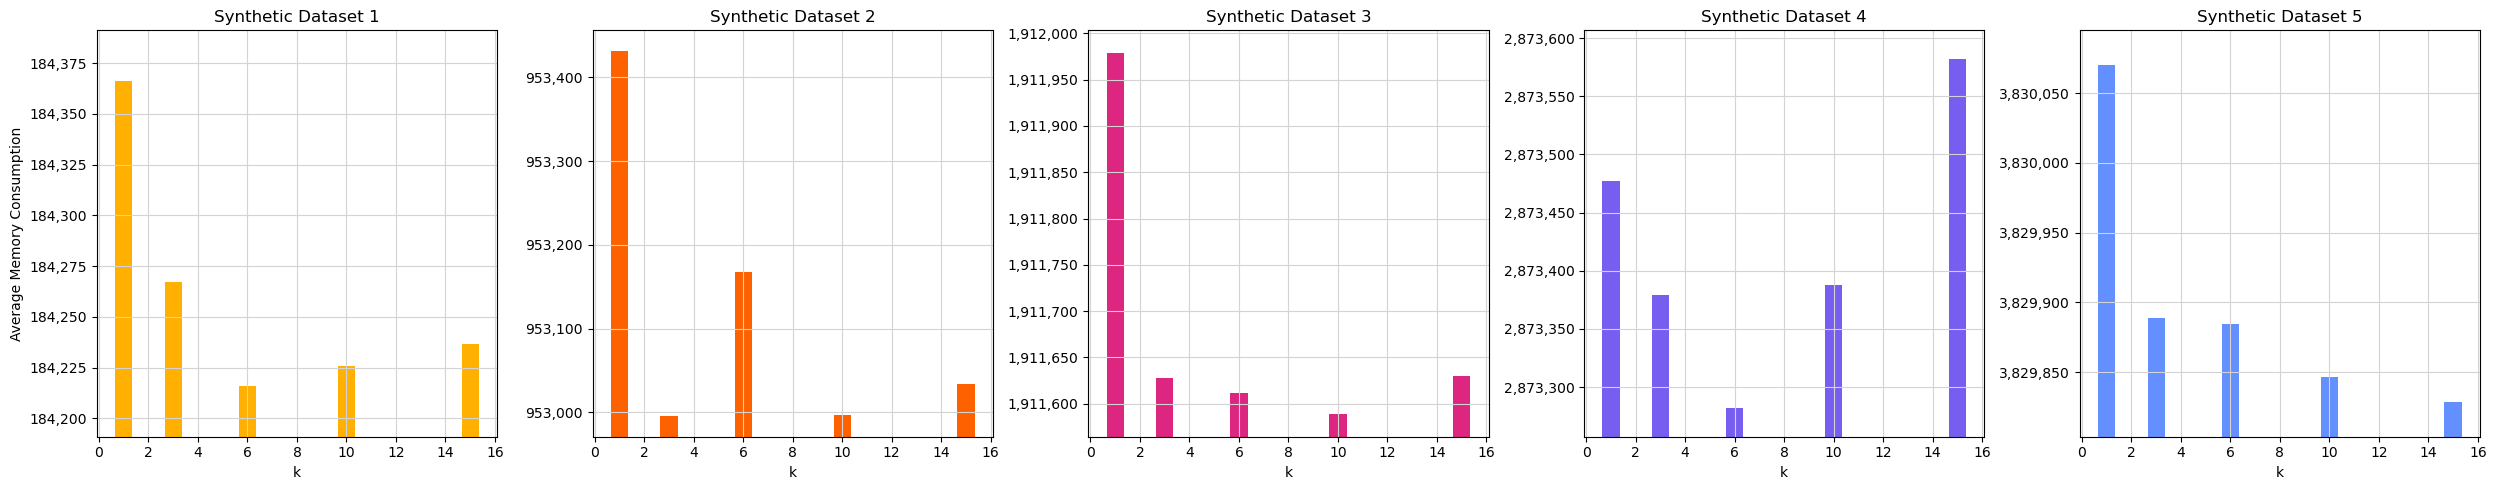

In [73]:
import matplotlib.ticker as mticker

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=False, sharey=False)

# Bar width
bar_width = 0.7

# Define a function to set axis limits and disable scientific notation
def set_axis_limits(ax, y):
    ax.set_ylim([min(y) - 25, max(y) + 25])
    ax.ticklabel_format(style='plain', axis='y')  # Disable scientific notation
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))  # Format the y-axis labels

# Plot for the first runtime list
axes[0].bar(ks, s_mem, color='#FFB000', width=bar_width)
# for i, avg in enumerate(s_mem):
#     axes[0].text(ks[i], avg, f'{avg:.0f}', ha='center', va='bottom', fontsize=10, color='#000000', fontweight='bold')
axes[0].set_title('Synthetic Dataset 1')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Average Memory Consumption')
axes[0].grid(c="#d3d3d3")
set_axis_limits(axes[0], s_mem)

# Plot for the second runtime list
axes[1].bar(ks, med_mem, color='#FE6100', width=bar_width)
# for i, avg in enumerate(med_mem):
#     axes[1].text(ks[i], avg, f'{avg:.0f}', ha='center', va='bottom', fontsize=10, color='#000000', fontweight='bold')
axes[1].set_title('Synthetic Dataset 2')
axes[1].set_xlabel('k')
axes[1].grid(c="#d3d3d3")
set_axis_limits(axes[1], med_mem)

# Plot for the third runtime list
axes[2].bar(ks, large_mem, color='#DC267F', width=bar_width)
# for i, avg in enumerate(large_mem):
#     axes[2].text(ks[i], avg, f'{avg:.0f}', ha='center', va='bottom', fontsize=10, color='#000000', fontweight='bold')
axes[2].set_title('Synthetic Dataset 3')
axes[2].set_xlabel('k')
axes[2].grid(c="#d3d3d3")
set_axis_limits(axes[2], large_mem)

# Plot for the fourth runtime list
axes[3].bar(ks, xl_mem, color='#785EF0', width=bar_width)
# for i, avg in enumerate(xl_mem):
#     axes[3].text(ks[i], avg, f'{avg:.0f}', ha='center', va='bottom', fontsize=10, color='#000000', fontweight='bold')
axes[3].set_title('Synthetic Dataset 4')
axes[3].set_xlabel('k')
axes[3].grid(c="#d3d3d3")
set_axis_limits(axes[3], xl_mem)

# Plot for the fifth runtime list
axes[4].bar(ks, xxl_mem, color='#648FFF', width=bar_width)
# for i, avg in enumerate(xxl_mem):
#     axes[4].text(ks[i], avg, f'{avg:.0f}', ha='center', va='bottom', fontsize=10, color='#000000', fontweight='bold')
axes[4].set_title('Synthetic Dataset 5')
axes[4].set_xlabel('k')
axes[4].grid(c="#d3d3d3")
set_axis_limits(axes[4], xxl_mem)

# Adjust layout
plt.tight_layout()
plt.show()